# Building a deep belief network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.append('../..')

from logger import setup_logging
from models import DBN
from utils import (
    dataset,
    test,
    train,
    utils,
    visualisation
)

D:\anaconda3\envs\dbn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LOG_CONFIG_PATH = os.path.join(os.path.abspath(".."), "logger", "logger_config.json")
LOG_DIR   = os.path.join(os.path.abspath(".."), "logs")
DATA_DIR  = os.path.join(os.path.abspath(".."), "data")
IMAGE_DIR = os.path.join(os.path.abspath(".."), "images")

In [3]:
DATA_DIR

'E:\\xxx\\APT-Detection\\dbn-based-nids\\notebooks\\data'

Check if GPU is active.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [5]:
utils.mkdir(LOG_DIR)
setup_logging(save_dir=LOG_DIR, log_config=LOG_CONFIG_PATH)

### Create the DataLoader

In [6]:
# Get the datasets
train_data, val_data, test_data = dataset.get_dataset(data_path=DATA_DIR, balanced=True)

# How many instances have we got?
print('# instances in training set: ', len(train_data))
print('# instances in validation set: ', len(val_data))
print('# instances in testing set: ', len(test_data))

batch_size = 128

# Create the dataloaders - for training, validation and testing
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# instances in training set:  1256961
# instances in validation set:  485146
# instances in testing set:  485145


### Instantiate the network, the loss function and the optimizer

In [8]:
# Defining some input variables
n_classes = 7
num_epochs = 3

# Creating a DBN
model = DBN(n_visible=49,
            n_hidden=(128, 64),
            k=(1, 1),
            learning_rate=(0.1, 0.1),
            momentum=(0, 0),
            decay=(0, 0), 
            batch_size=[64, 64],
            num_epochs=[1, 1],
            device=device)

# Training a DBN
model.fit(train_loader)

# Creating the optimzers
optimizer = [optim.Adam(m.parameters(), lr=0.001) for m in model.models]
optimizer.append(optim.Adam(model.fc.parameters(), lr=0.001))

INFO 2023-06-13 17:35:18,907 | DBN.py:184 | Fitting layer 1/2


100%|██████████████████████████████████████████████████████████████████████████████| 9821/9821 [03:47<00:00, 43.10it/s]

INFO 2023-06-13 17:39:06,790 | RBM.py:269 | Epoch 1/1 - MSE: 6.940215587615967 - Pseudo-Likelihood: -13.225956916809082


INFO 2023-06-13 17:39:08,172 | DBN.py:184 | Fitting layer 2/2


100%|███████████████████████████████████████████████████████████████████████████| 19641/19641 [00:42<00:00, 457.86it/s]

INFO 2023-06-13 17:39:51,073 | RBM.py:269 | Epoch 1/1 - MSE: 19.670570373535156 - Pseudo-Likelihood: -36.599998474121094


In [9]:
print(model)

DBN(
  (fc): Linear(in_features=64, out_features=7, bias=True)
)


In [11]:
criterion = nn.CrossEntropyLoss()

### Train it

In [12]:
history = train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device)

training_loss = history['train']['loss']
training_accuracy = history['train']['accuracy']
train_output_true = history['train']['output_true']
train_output_pred = history['train']['output_pred']

validation_loss = history['valid']['loss']
validation_accuracy = history['valid']['accuracy']
valid_output_true = history['valid']['output_true']
valid_output_pred = history['valid']['output_pred']

INFO 2023-06-13 17:41:23,343 | train.py:80 | Epoch 1/3:


100%|██████████████████████████████████████████████████████████████████████████████| 9821/9821 [03:31<00:00, 46.48it/s]


INFO 2023-06-13 17:46:09,554 | train.py:153 | loss: 0.11711132666885483 - acc: 0.9591856867476397 - val_loss: 0.02698569638801744 - val_acc: 0.9904338075548391
INFO 2023-06-13 17:46:09,555 | train.py:80 | Epoch 2/3:


100%|██████████████████████████████████████████████████████████████████████████████| 9821/9821 [03:30<00:00, 46.56it/s]


INFO 2023-06-13 17:50:54,957 | train.py:153 | loss: 0.04232759416906002 - acc: 0.9826661288615955 - val_loss: 0.03818324996111251 - val_acc: 0.9809954116905014
INFO 2023-06-13 17:50:54,958 | train.py:80 | Epoch 3/3:


100%|██████████████████████████████████████████████████████████████████████████████| 9821/9821 [03:31<00:00, 46.38it/s]


INFO 2023-06-13 17:55:45,005 | train.py:153 | loss: 0.03578556123929632 - acc: 0.9850162415540339 - val_loss: 0.024664626583146592 - val_acc: 0.9884199807892882
INFO 2023-06-13 17:55:45,006 | train.py:155 | Finished Training


### Plot loss vs iterations

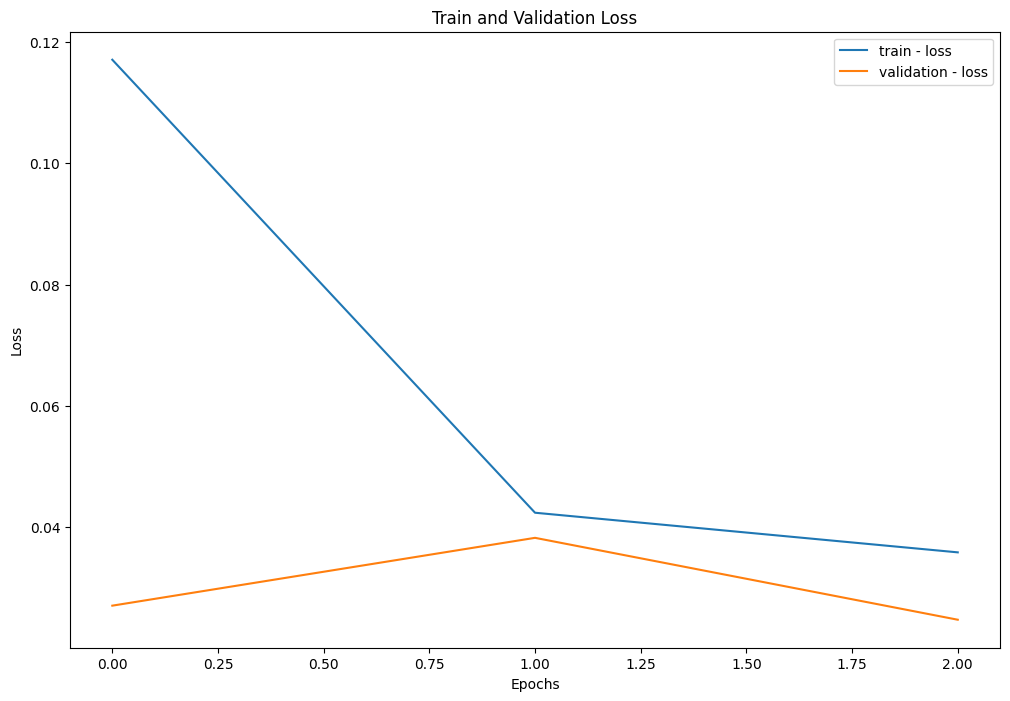

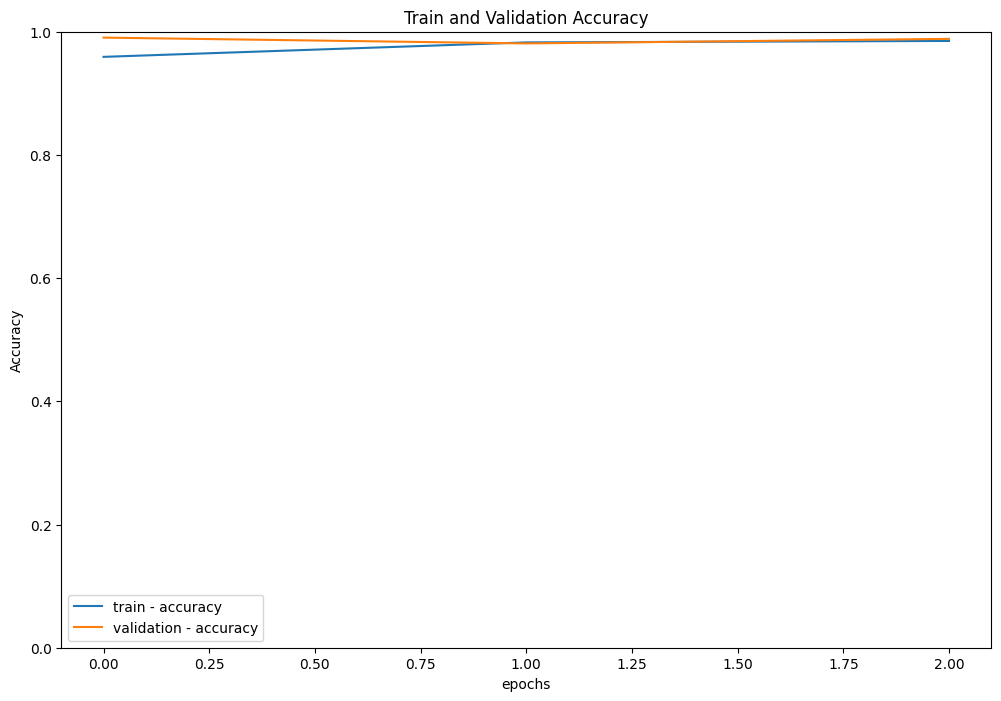

In [14]:
fig = plt.figure(figsize=(12, 8))
plt.plot(training_loss, label='train - loss')
plt.plot(validation_loss, label='validation - loss')
plt.title("Train and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.plot(training_accuracy, label='train - accuracy')
plt.plot(validation_accuracy, label='validation - accuracy')
plt.title("Train and Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc="best")
plt.show()

### Plot confusion matrix

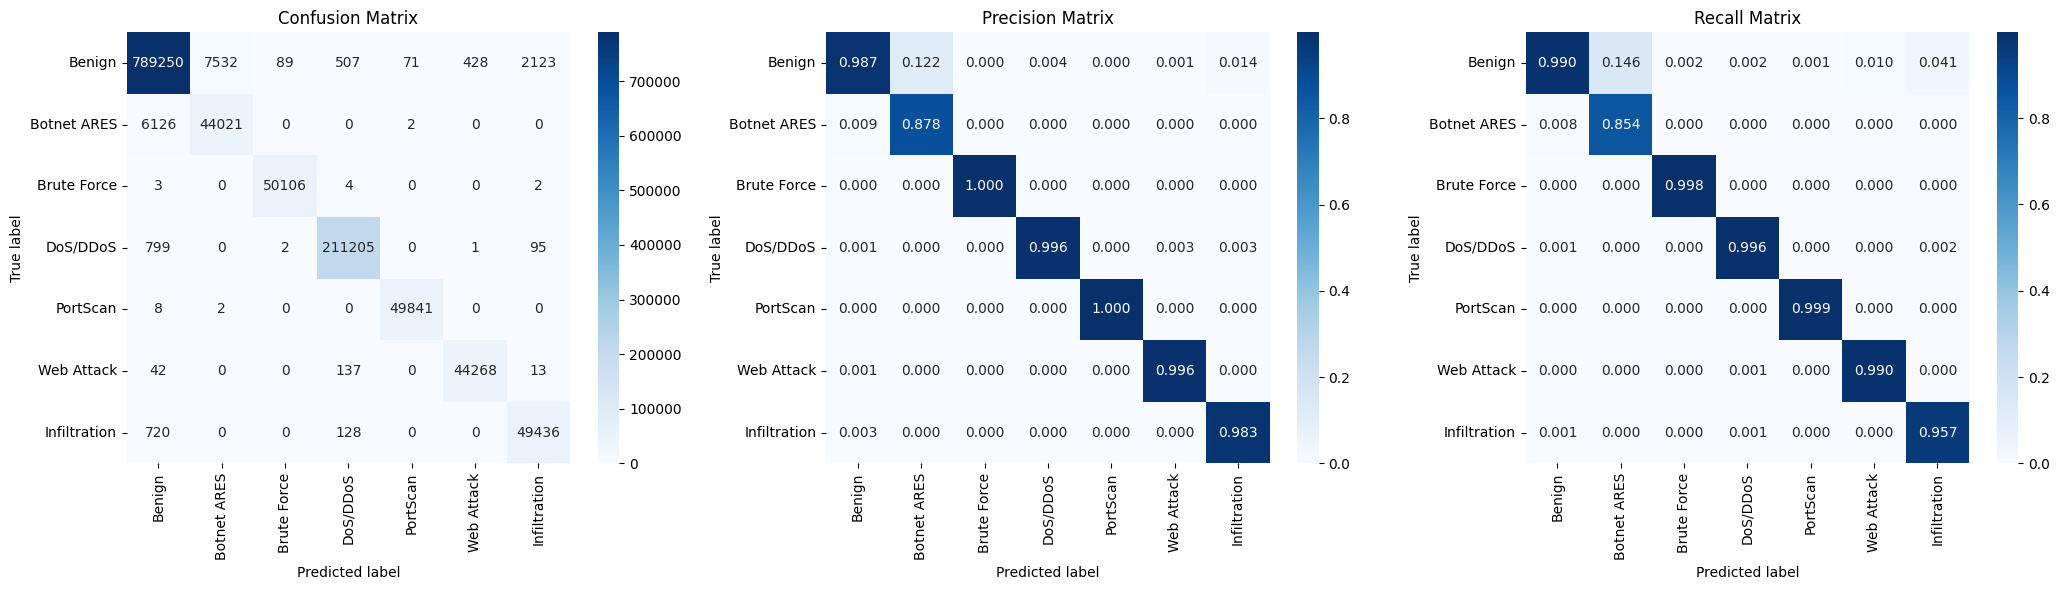

In [15]:
labels = ['Benign', 'Botnet ARES', 'Brute Force', 'DoS/DDoS', 'PortScan', 'Web Attack', 'Infiltration']

visualisation.plot_confusion_matrix(y_true=train_output_true,
                                    y_pred=train_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="bal_dbn_train_confusion_matrix.pdf")

In [16]:
from sklearn.metrics import classification_report

print("Training Set -- Classification Report", end="\n\n")
print(classification_report(train_output_true, train_output_pred, target_names=labels))

Training Set -- Classification Report

              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99    800000
 Botnet ARES       0.85      0.88      0.87     50149
 Brute Force       1.00      1.00      1.00     50115
    DoS/DDoS       1.00      1.00      1.00    212102
    PortScan       1.00      1.00      1.00     49851
  Web Attack       0.99      1.00      0.99     44460
Infiltration       0.96      0.98      0.97     50284

    accuracy                           0.99   1256961
   macro avg       0.97      0.98      0.97   1256961
weighted avg       0.99      0.99      0.99   1256961



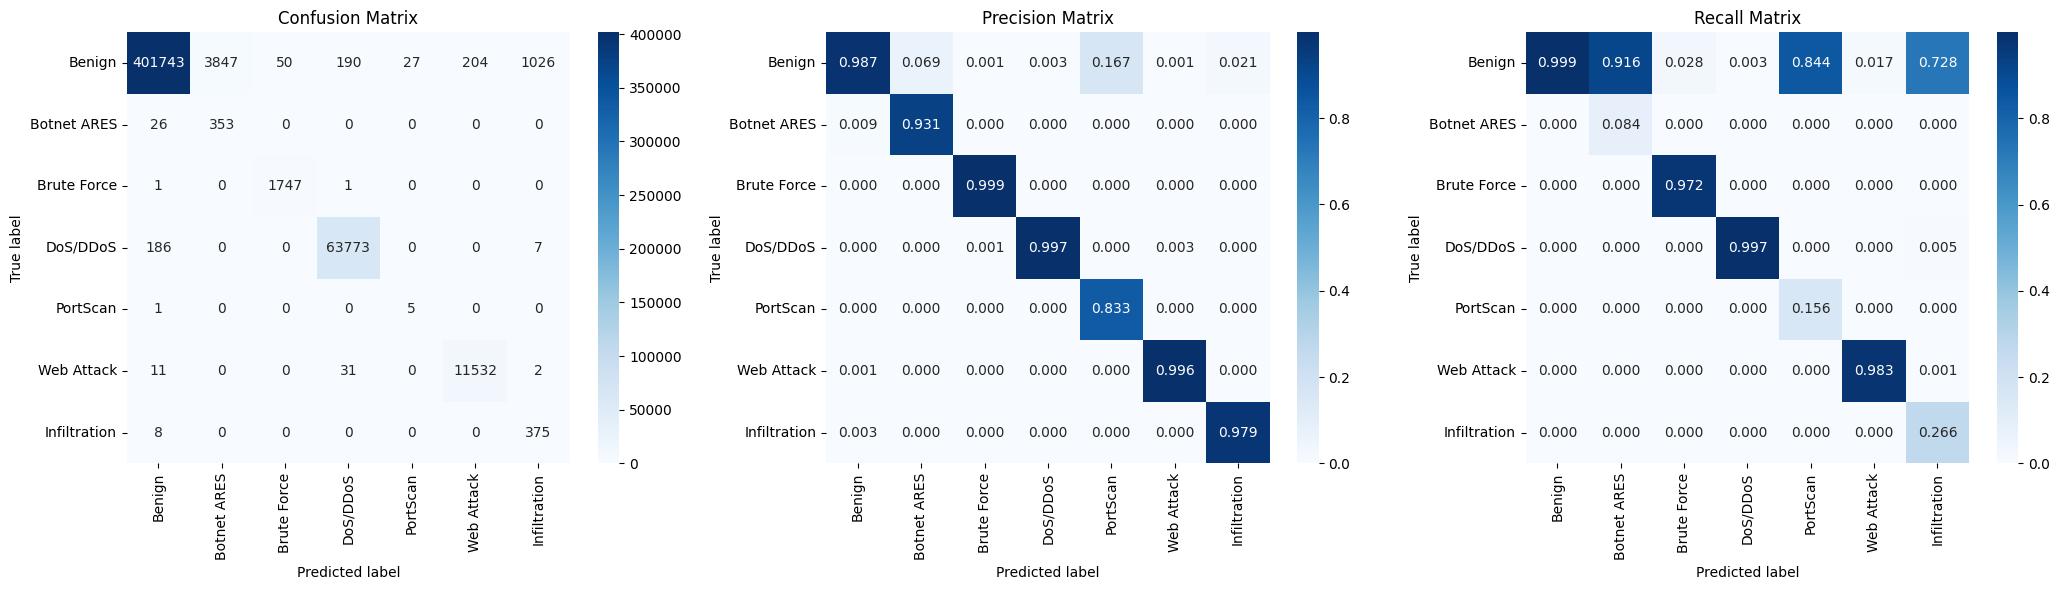

In [17]:
visualisation.plot_confusion_matrix(y_true=valid_output_true,
                                    y_pred=valid_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="bal_dbn_valid_confusion_matrix.pdf")

In [18]:
print("Validation Set -- Classification Report", end="\n\n")
print(classification_report(valid_output_true, valid_output_pred, target_names=labels))

Validation Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      0.99      0.99    407087
 Botnet ARES       0.08      0.93      0.15       379
 Brute Force       0.97      1.00      0.99      1749
    DoS/DDoS       1.00      1.00      1.00     63966
    PortScan       0.16      0.83      0.26         6
  Web Attack       0.98      1.00      0.99     11576
Infiltration       0.27      0.98      0.42       383

    accuracy                           0.99    485146
   macro avg       0.64      0.96      0.69    485146
weighted avg       1.00      0.99      0.99    485146



### Test it

In [19]:
#################
### TEST LOOP ###
#################
history = test(model, criterion, test_loader, device)

test_output_true = history['test']['output_true']
test_output_pred = history['test']['output_pred']
test_output_pred_prob = history['test']['output_pred_prob']

100%|██████████████████████████████████████████████████████████████████████████████| 3791/3791 [01:16<00:00, 49.28it/s]

INFO 2023-06-13 17:58:24,517 | test.py:82 | Test loss: 0.02493175845580086, Test accuracy: 0.9884385080749054


### Classification Report

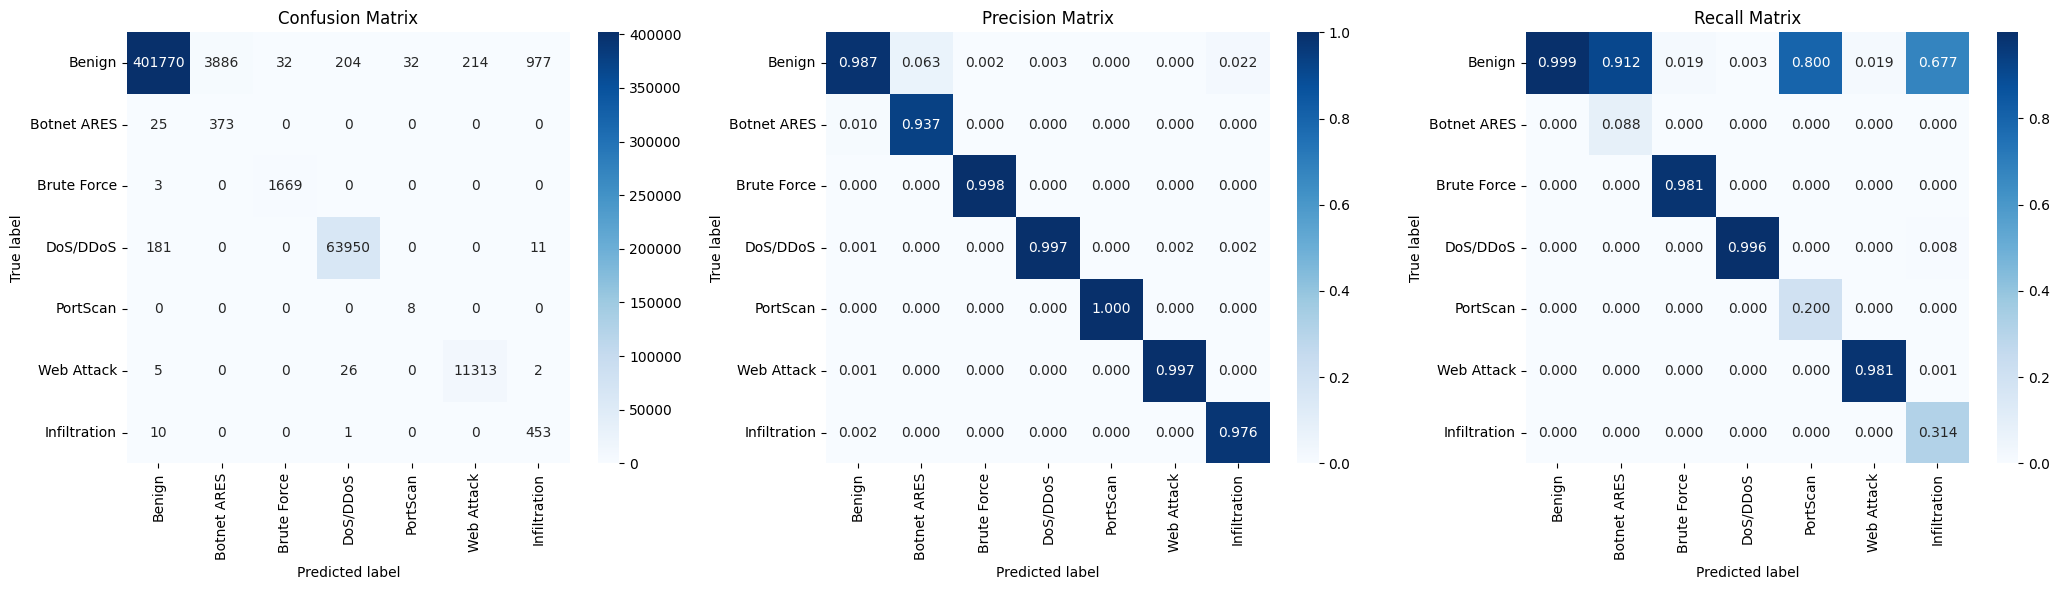

In [20]:
visualisation.plot_confusion_matrix(y_true=test_output_true,
                                    y_pred=test_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="bal_dbn_test_confusion_matrix.pdf")

In [21]:
print("Testing Set -- Classification Report", end="\n\n")
print(classification_report(test_output_true, test_output_pred, target_names=labels))

Testing Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      0.99      0.99    407115
 Botnet ARES       0.09      0.94      0.16       398
 Brute Force       0.98      1.00      0.99      1672
    DoS/DDoS       1.00      1.00      1.00     64142
    PortScan       0.20      1.00      0.33         8
  Web Attack       0.98      1.00      0.99     11346
Infiltration       0.31      0.98      0.48       464

    accuracy                           0.99    485145
   macro avg       0.65      0.98      0.71    485145
weighted avg       1.00      0.99      0.99    485145



### Plot ROC curve

In [22]:
y_test = pd.get_dummies(test_output_true).values
y_score = np.array(test_output_pred_prob)

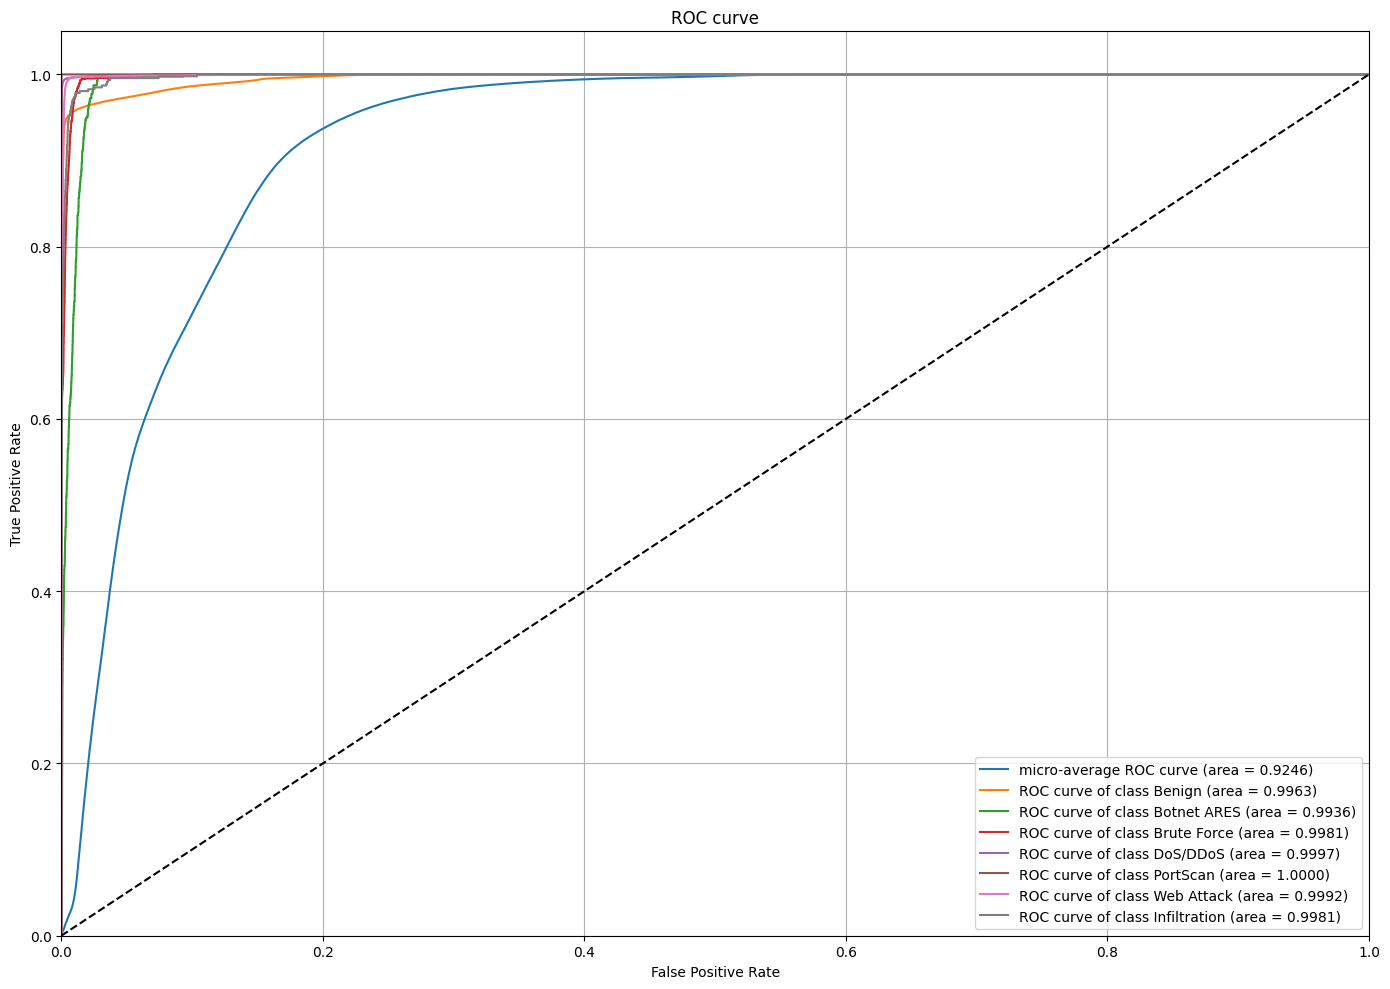

In [23]:
visualisation.plot_roc_curve(y_test=y_test,
                             y_score=y_score,
                             labels=labels,
                             save=True,
                             save_dir=IMAGE_DIR,
                             filename="bal_dbn_roc_curve.pdf")

### Plot Precision vs. Recall curve

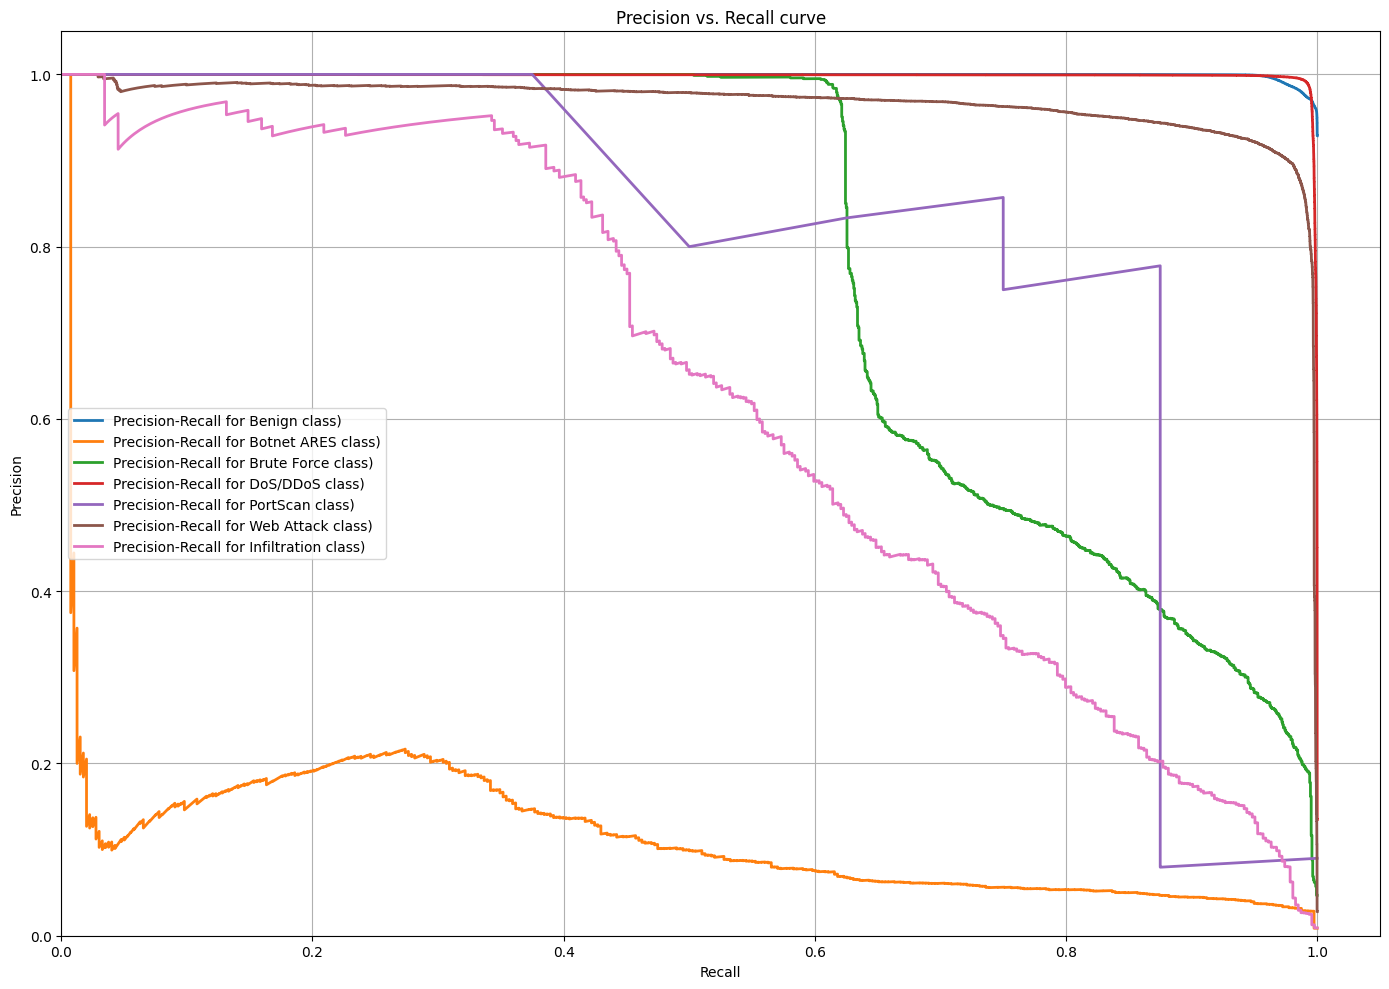

In [24]:
visualisation.plot_precision_recall_curve(y_test=y_test,
                                          y_score=y_score,
                                          labels=labels,
                                          save=True,
                                          save_dir=IMAGE_DIR,
                                          filename="bal_dbn_prec_recall_curve.pdf")

### Save Model

In [25]:
path = '../../checkpoints/bal_deep_belief_network.pt'
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            }, path)